<a href="https://colab.research.google.com/github/jeffheaton/app_deep_learning/blob/main/t81_558_class_09_5_blink.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# T81-558: Applications of Deep Neural Networks

**Module 9: Facial Recognition**

- Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), McKelvey School of Engineering, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
- For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).


# Module 9 Material

- Part 9.1: Detecting Faces in an Image [[Video]](https://www.youtube.com/watch?v=Hpp3D3P2iWQ&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_1_faces.ipynb)
- Part 9.2: Detecting Facial Features [[Video]](https://www.youtube.com/watch?v=AblTbq0T2wE&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_2_face_features.ipynb)
- Part 9.3: Reality Augmentation [[Video]](https://www.youtube.com/watch?v=jfZDiRxx5Bc&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_3_reality_augmentation.ipynb)
- Part 9.4: Application: Emotion Detection [[Video]](https://www.youtube.com/watch?v=F0H6vojQhE8&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_4_emotion.ipynb)
- **Part 9.5: Application: Blink Efficiency** [[Video]](https://www.youtube.com/watch?v=96LPEStHCUA&list=PLjy4p-07OYzulelvJ5KVaT2pDlxivl_BN) [[Notebook]](t81_558_class_09_5_blink.ipynb)


# Google CoLab Instructions

The following code checks that Google CoLab is and sets up the correct hardware settings for PyTorch.


In [1]:
try:
    import google.colab
    COLAB = True
    print("Note: using Google CoLab")
except:
    print("Note: not using Google CoLab")
    COLAB = False

# Make use of a GPU or MPS (Apple) if one is available.  (see module 3.2)
import torch

device = (
    "mps"
    if getattr(torch, "has_mps", False)
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")


if device!='cuda':
  print("*******WARNING, this notebook requires a CUDA GPU****")
  print("This notebook will not work correctly!")

Note: using Google CoLab
Using device: cuda


# Part 9.5: Blink Efficiency

In the transformative realm of machine learning, the frontier of healthcare has emerged as a prime domain for the application of these innovative techniques. With the capacity to predict, classify, and even potentially prescribe, machine learning is revolutionizing medical diagnosis and treatment strategies. One such application is the precise mapping and recognition of facial landmarks. These anatomical points on the human face, not limited merely to identity verification or augmented reality applications, possess profound significance in the medical sector.

Facial landmarks, a series of strategically identified points on a face, can be traced and tracked to gauge a range of physiological and anatomical anomalies. From understanding facial asymmetry to identifying features of genetic disorders, these landmarks offer a nuanced understanding of the facial anatomy, allowing for the diagnosis and monitoring of various medical conditions.

One intriguing application is in the diagnosis of "lagophthalmos" – a condition where an individual cannot close one or both eyes completely during a blink. Early detection is vital as the incomplete closure of the eye can lead to complications like dry eye and even corneal ulcerations. Traditional methods, often relying on subjective assessments or invasive procedures, sometimes miss the subtle onset of this condition. However, with machine learning's prowess and the use of video analysis, we can now obtain a dynamic understanding of the blink cycle.

By analyzing videos of the blink cycle using facial landmark detection, it becomes feasible to accurately measure the extent of eyelid closure in real-time, identifying even minor discrepancies in the blink mechanism. Machine learning models can be trained to detect the specific landmarks associated with the upper and lower eyelids, evaluating their proximity and movement during a blink. This objective and quantifiable method ensures timely diagnosis and intervention, enhancing patient outcomes.

In this section, we will delve deep into the technicalities of how machine learning aids in the detection of lagophthalmos using facial landmarks. We will explore the algorithms, methodologies, and challenges involved, and how this pioneering approach is making waves in the field of ophthalmology.

We begin by installing SPIGA and Facenet.

In [2]:
# Setup SPIGA and facenet
!pip install facenet-pytorch
!git clone https://github.com/andresprados/SPIGA.git
%cd SPIGA/
!pip install -e .

fatal: destination path 'SPIGA' already exists and is not an empty directory.
/content/SPIGA
Obtaining file:///content/SPIGA
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for spiga (pyproject.toml) ... done
  Created wheel for spiga: filename=spiga-0.0.6-0.editable-py3-none-any.whl size=7961 sha256=3f6d1663125d59f698dd0c4efb48d54ee3c287360bc73a9c310145c803a9f52f
  Stored in directory: /tmp/pip-ephem-wheel-cache-88g3obqj/wheels/51/78/17/4d636d7d4147e7d7a403fcd06d77681c57262817b7ae678952
Successfully built spiga
  Attempting uninstall: spiga
    Found existing installation: spiga 0.0.6
    Uninstalling spiga-0.0.6:
      Successfully uninstalled spiga-0.0.6


We will measure blink efficency by looking at how far open each of the patients eyes are during a blink cycle. We will analyze each frame of the video clip and measure the area between the eyelids for both eyes over each frame. We load an image of a patient for analysis. Note, that this image was used with permission of the pateint.

In [3]:
import requests
import cv2
import numpy as np
from PIL import Image, ImageDraw
from facenet_pytorch import MTCNN

#url = "https://s3.amazonaws.com/data.heatonresearch.com/images/jeff/about-jeff-heaton-2020.jpg"
url = "https://data.heatonresearch.com/images/wustl/data/blink-frame.jpg"

# Download the image using requests
response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
response.raise_for_status()

# Convert the downloaded bytes to a numpy array
image = np.asarray(bytearray(response.content), dtype="uint8")

# Decode the numpy array to an OpenCV image
img = cv2.imdecode(image, cv2.IMREAD_COLOR)

# Convert the OpenCV image (NumPy array) to a PIL Image
image_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
image_pil = Image.fromarray(image_rgb)

We are now ready to call MTCNN to find the face and SPIGA to obtain the facial features.

In [4]:
from spiga.inference.config import ModelConfig
from spiga.inference.framework import SPIGAFramework
import copy

mtcnn = MTCNN(keep_all=False, device=device)

# Detect faces
boxes, _ = mtcnn.detect(image_pil)

# Create a bounding box for the face we just detected.
bbox = [
    boxes[0][0],
    boxes[0][1],
    boxes[0][2],
    boxes[0][3]]

# Process image
dataset = 'wflw'
processor = SPIGAFramework(ModelConfig(dataset))
features = processor.inference(img, [bbox])

# Prepare variables
canvas = copy.deepcopy(img)
landmarks = np.array(features['landmarks'][0])
headpose = np.array(features['headpose'][0])

SPIGA model loaded!


/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4298: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:4236: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


# Analyzing and Measure Eye Area

We must complete several steps to determine the difference in area between two eyes in an image. The first step is determining the number of pixels per millimeter in the computer image. This technique allows us to convert pixel areas on the image to actual millimeter lengths and areas. To do this, we will measure the number of pixels between the two pupils (landmarks 96 and 97) in the patient's eyes. We refer to the distance between the two pupils as the pupillary distance, which is 63 millimeters for most people. By dividing 63 by pupillary length, we can calculate how to convert pixels to millimeters; this is the **pix2mm** variable in the code below.

Next, we will use each eye's landmark perimeter coordinates to calculate each eye's area. We calculate this area with the shoelace method. The [shoelace formula](https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates), also known as Gauss's area formula or the surveyor's formula, is a method for finding the area of a polygon when given the coordinates of its vertices. The name "shoelace" comes from the "crisscross" manner in which the coordinates are used to compute the area, resembling the lacing of shoes.

Next, we measure the polygon of each eye and overlay a blue tone to show where the eyes were detected. Once this is complete, we display the area of each eye and the difference between them. The bigger the difference, the more indication of a problem.

1 pixel is equal to 0.3040356700178748 mm
here


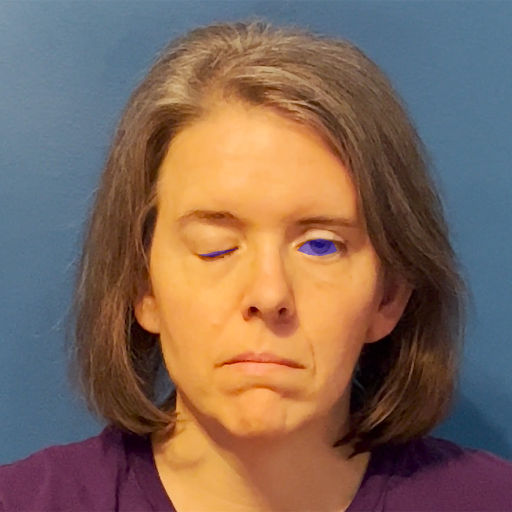

Right eye area: 34.26379691188049 mm^2
Left eye area: 170.46102686181257 mm^2
Difference: 136.19722994993208 mm^2


In [5]:
from google.colab.patches import cv2_imshow

# determine scale of image
pupillary_distance = abs(landmarks[96] - landmarks[97])[0]
pix2mm = 63/pupillary_distance
print(f"1 pixel is equal to {pix2mm} mm")

# Shoelace, https://stackoverflow.com/questions/24467972/calculate-area-of-polygon-given-x-y-coordinates
def PolyArea(x,y):
    return 0.5*np.abs(np.dot(x,np.roll(y,1))-np.dot(y,np.roll(x,1)))


def measure_polygon(canvas, contours, pix2mm, alpha=0.4, color=(255,0,0)):
  contours = np.array(contours)
  overlay = canvas.copy()
  pts = np.int32(contours)
  cv2.fillPoly(overlay, pts = [pts], color =color)
  canvas = cv2.addWeighted(overlay, alpha, canvas, 1 - alpha, 0)
  contours = contours*pix2mm
  x = contours[:,0]
  y = contours[:,1]
  return PolyArea(x,y), canvas
print("here")

# Show image results
right_eye_area, canvas = measure_polygon(
  canvas,
  [landmarks[60],
  landmarks[61],
  landmarks[62],
  landmarks[63],
  landmarks[64],
  landmarks[65],
  landmarks[66],
  landmarks[67]], pix2mm)

left_eye_area, canvas = measure_polygon(
  canvas,
  [landmarks[68],
  landmarks[69],
  landmarks[70],
  landmarks[71],
  landmarks[72],
  landmarks[73],
  landmarks[74],
  landmarks[75]], pix2mm)

# Show results
(h, w) = canvas.shape[:2]
canvas = cv2.resize(canvas, (512, int(h*512/w)))
cv2_imshow(canvas)

# Print results
print(f"Right eye area: {right_eye_area} mm^2")
print(f"Left eye area: {left_eye_area} mm^2")
d = abs(right_eye_area-left_eye_area)
print(f"Difference: {d} mm^2")